In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNet

In [2]:
tf.__version__

'2.16.1'

# **Visualizing Classes**

In [3]:
train_dir = '/Users/tanishamaheshwari/Downloads/archive/train/'
test_dir = '/Users/tanishamaheshwari/Downloads/archive/test/'

def Classes_Count(path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)
        if os.path.isdir(Full_Path):  # Ensure it's a directory
            Classes_Dict[Class] = len([f for f in os.listdir(Full_Path) if os.path.isfile(os.path.join(Full_Path, f))])
    
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

print("Training data count:")
print(Train_Count)
print("\nTest data count:")
print(Test_Count)


Training data count:
          Train
happy      7215
neutral    4965
sad        4830
fear       4097
angry      3995
surprise   3171
disgust     436

Test data count:
          Test
happy     1774
sad       1247
neutral   1233
fear      1024
angry      958
surprise   831
disgust    111


In [4]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

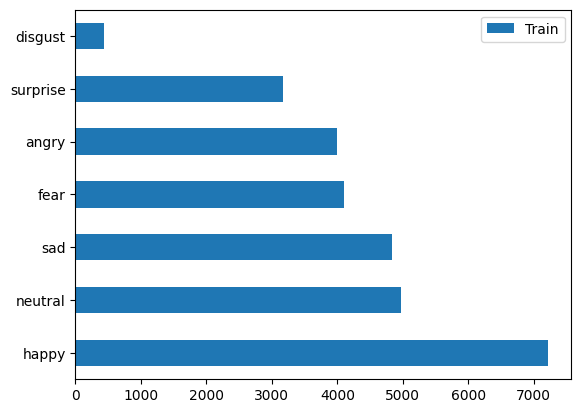

In [5]:
Train_Count.plot(kind='barh')

<Axes: >

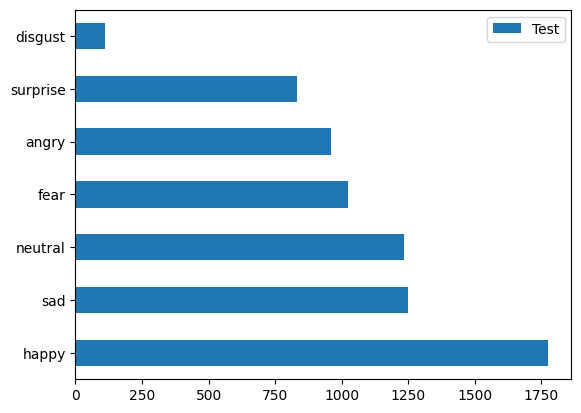

In [6]:
Test_Count.plot(kind='barh')

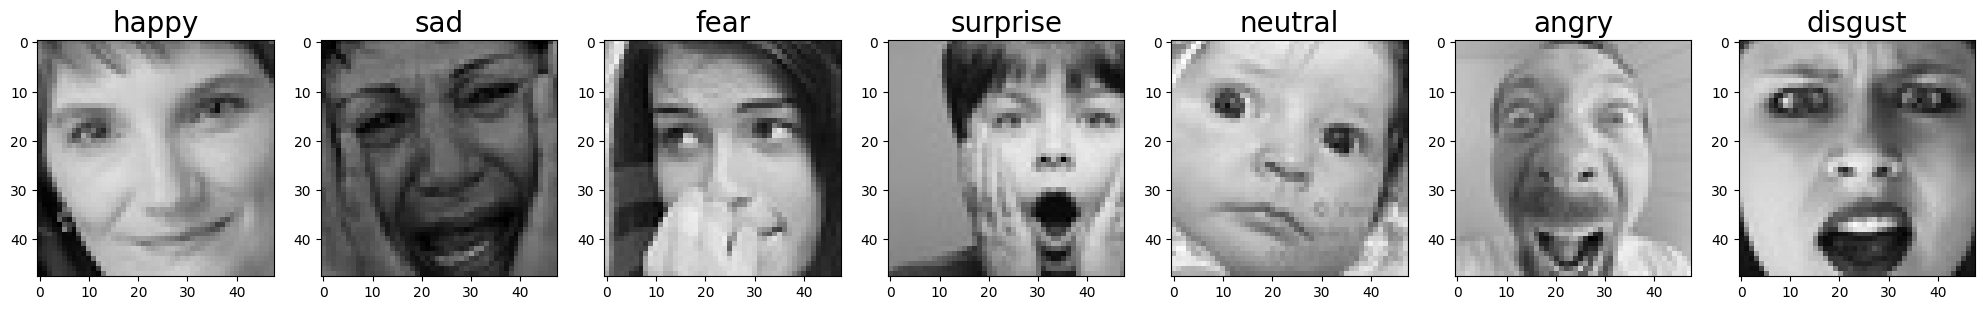

In [7]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '/Users/tanishamaheshwari/Downloads/archive/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

In [8]:
img_shape = 224
batch_size = 64
train_data_path = '/Users/tanishamaheshwari/Downloads/archive/train/'
test_data_path = '/Users/tanishamaheshwari/Downloads/archive/test/'

In [9]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **MobileNet Model**

In [10]:
import requests

url = 'https://storage.googleapis.com/tensorflow/keras-applications/mobilenet/mobilenet_1_0_224_tf_no_top.h5'
weights_path = 'mobilenet_1_0_224_tf_no_top.h5'

# Download the weights
response = requests.get(url, verify=False)
if response.status_code == 200:
    with open(weights_path, 'wb') as f:
        f.write(response.content)
else:
    print(f"Failed to download MobileNet weights. Status code: {response.status_code}")

# Load the model with local weights
MobileNet = tf.keras.applications.MobileNet(input_shape=(224, 224, 3),
                                            include_top=False,
                                            weights=weights_path)

MobileNet.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [11]:
# Freezing all layers except last 50

MobileNet.trainable = True

for layer in MobileNet.layers[:-50]:
    layer.trainable = False

In [12]:
def Create_MobileNet_Model():

    model = Sequential([
                      MobileNet,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [13]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()

In [14]:
MobileNet_Model = Create_MobileNet_Model()

MobileNet_Model.summary()

MobileNet_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,072,768 (11.72 MB)

 Non-trainable params: 156,096 (609.75 KB)

**Specifying Callbacks**

In [15]:
# Create Callback Checkpoint
checkpoint_path = "MobileNet_Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [17]:
def train_model(model, train_data, test_data, epochs, batch_size, callbacks=None):
    history = model.fit(train_data,
                        validation_data=test_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks)
    
    # Print training progress after each epoch
    for epoch in range(1, epochs + 1):
        print("Epoch {}/{}".format(epoch, epochs))
        print("Training - loss: {:.4f}, accuracy: {:.4f}".format(history.history['loss'][epoch - 1], 
                                                                 history.history['accuracy'][epoch - 1]))
        print("Validation - loss: {:.4f}, accuracy: {:.4f}".format(history.history['val_loss'][epoch - 1], 
                                                                   history.history['val_accuracy'][epoch - 1]))
        print("-" * 40)
    
    return history

# Usage example
epochs = 60
batch_size = 64

MobileNet_history = train_model(MobileNet_Model, train_data, test_data, epochs, batch_size, callbacks=callbacks)


Epoch 1/60


# **Evaluating MobileNet**

In [ ]:
MobileNet_Score = MobileNet_Model.evaluate(test_data)

print("Test Loss:     {:.5f}".format(MobileNet_Score[0]))
print("Test Accuracy: {:.2f}%".format(MobileNet_Score[1] * 100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 95s 835ms/step - accuracy: 0.6119 - loss: 1.0334 - precision: 0.7280 - recall: 0.5024
Test Loss:     0.93176
Test Accuracy: 65.63%


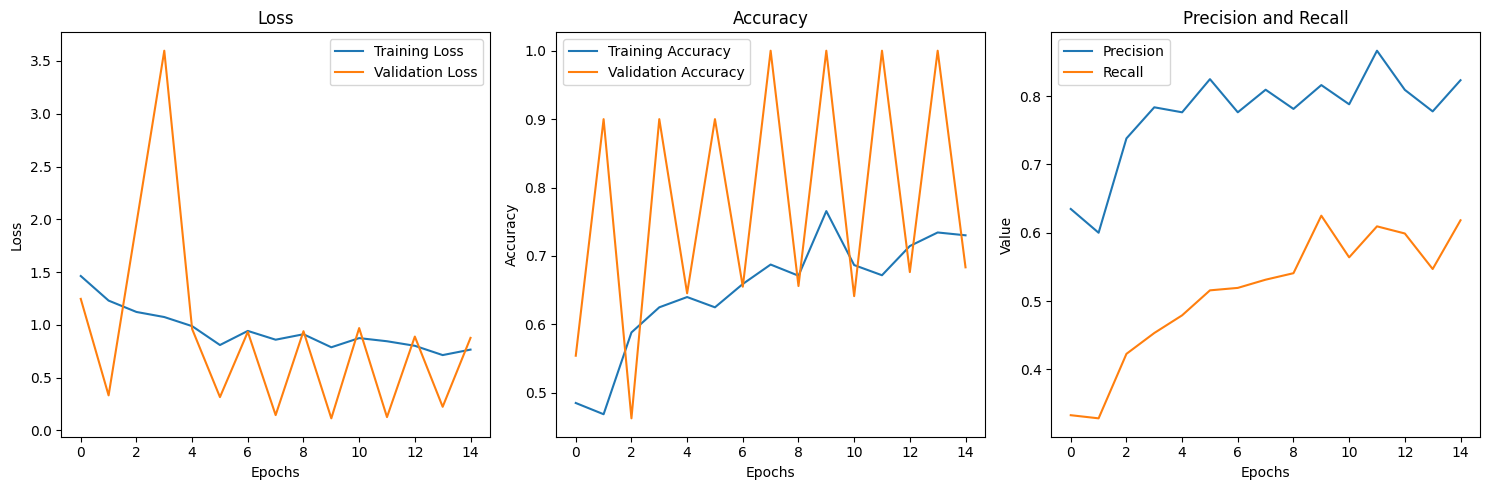

In [ ]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    precision = history.history["precision"]
    recall = history.history["recall"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot precision and recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, precision, label="Precision")
    plt.plot(epochs, recall, label="Recall")
    plt.title("Precision and Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_curves function after training
plot_curves(MobileNet_history)


In [ ]:
MobileNet_Predictions = MobileNet_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
MobileNet_Predictions = np.argmax(MobileNet_Predictions, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 101s 882ms/step


In [ ]:
history = MobileNet_history
final_accuracy = history.history['accuracy'][-1]
final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]
final_val_loss = history.history['val_loss'][-1]
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))

******** Final Metrics ********
Final Accuracy        : 73.02%
Final Precision       : 82.35%
Final Recall          : 61.83%
Final Validation Loss : 0.8764
Final F1 Score        : 0.706


Text(0.5, 1.0, 'MobileNet Confusion Matrix')

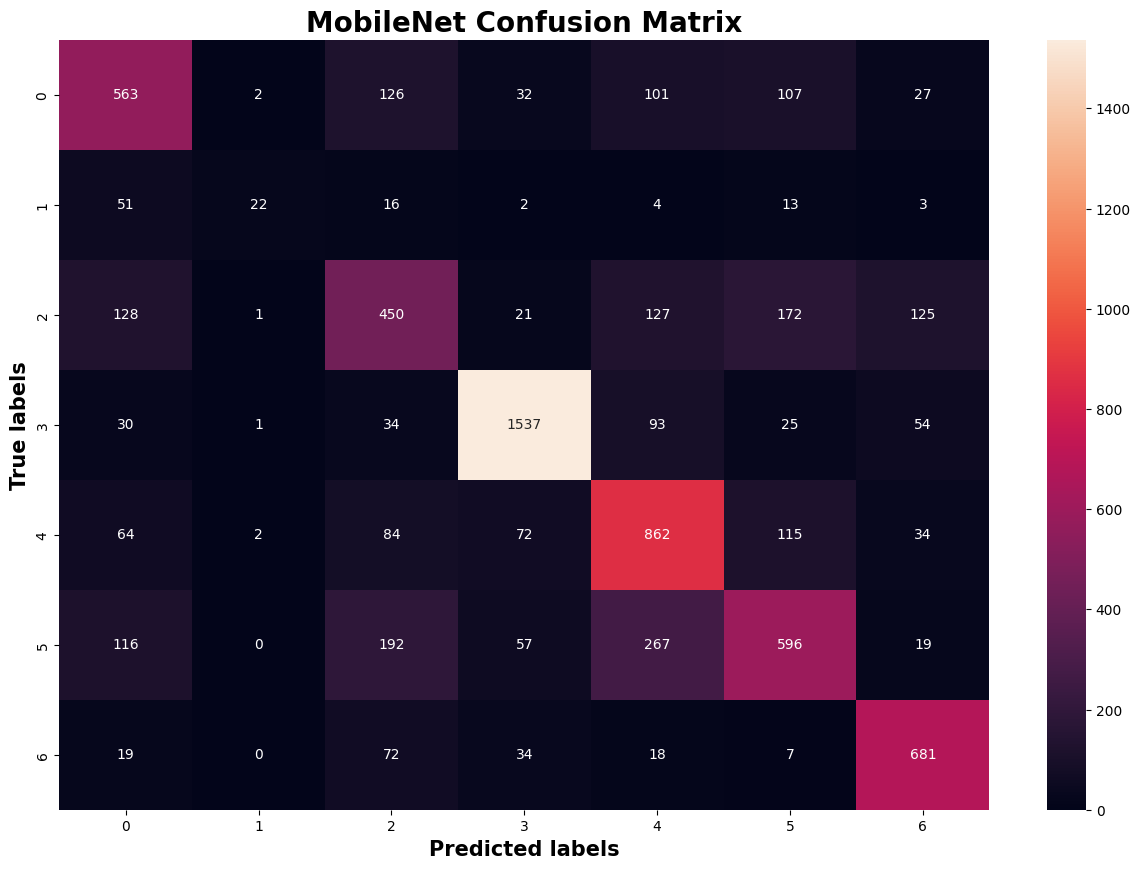

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, MobileNet_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('MobileNet Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [ ]:
class_indices = test_data.class_indices
Emotion_Classes = [key.capitalize() for key in class_indices.keys()]
print(Emotion_Classes)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


**MobileNet Predictions**

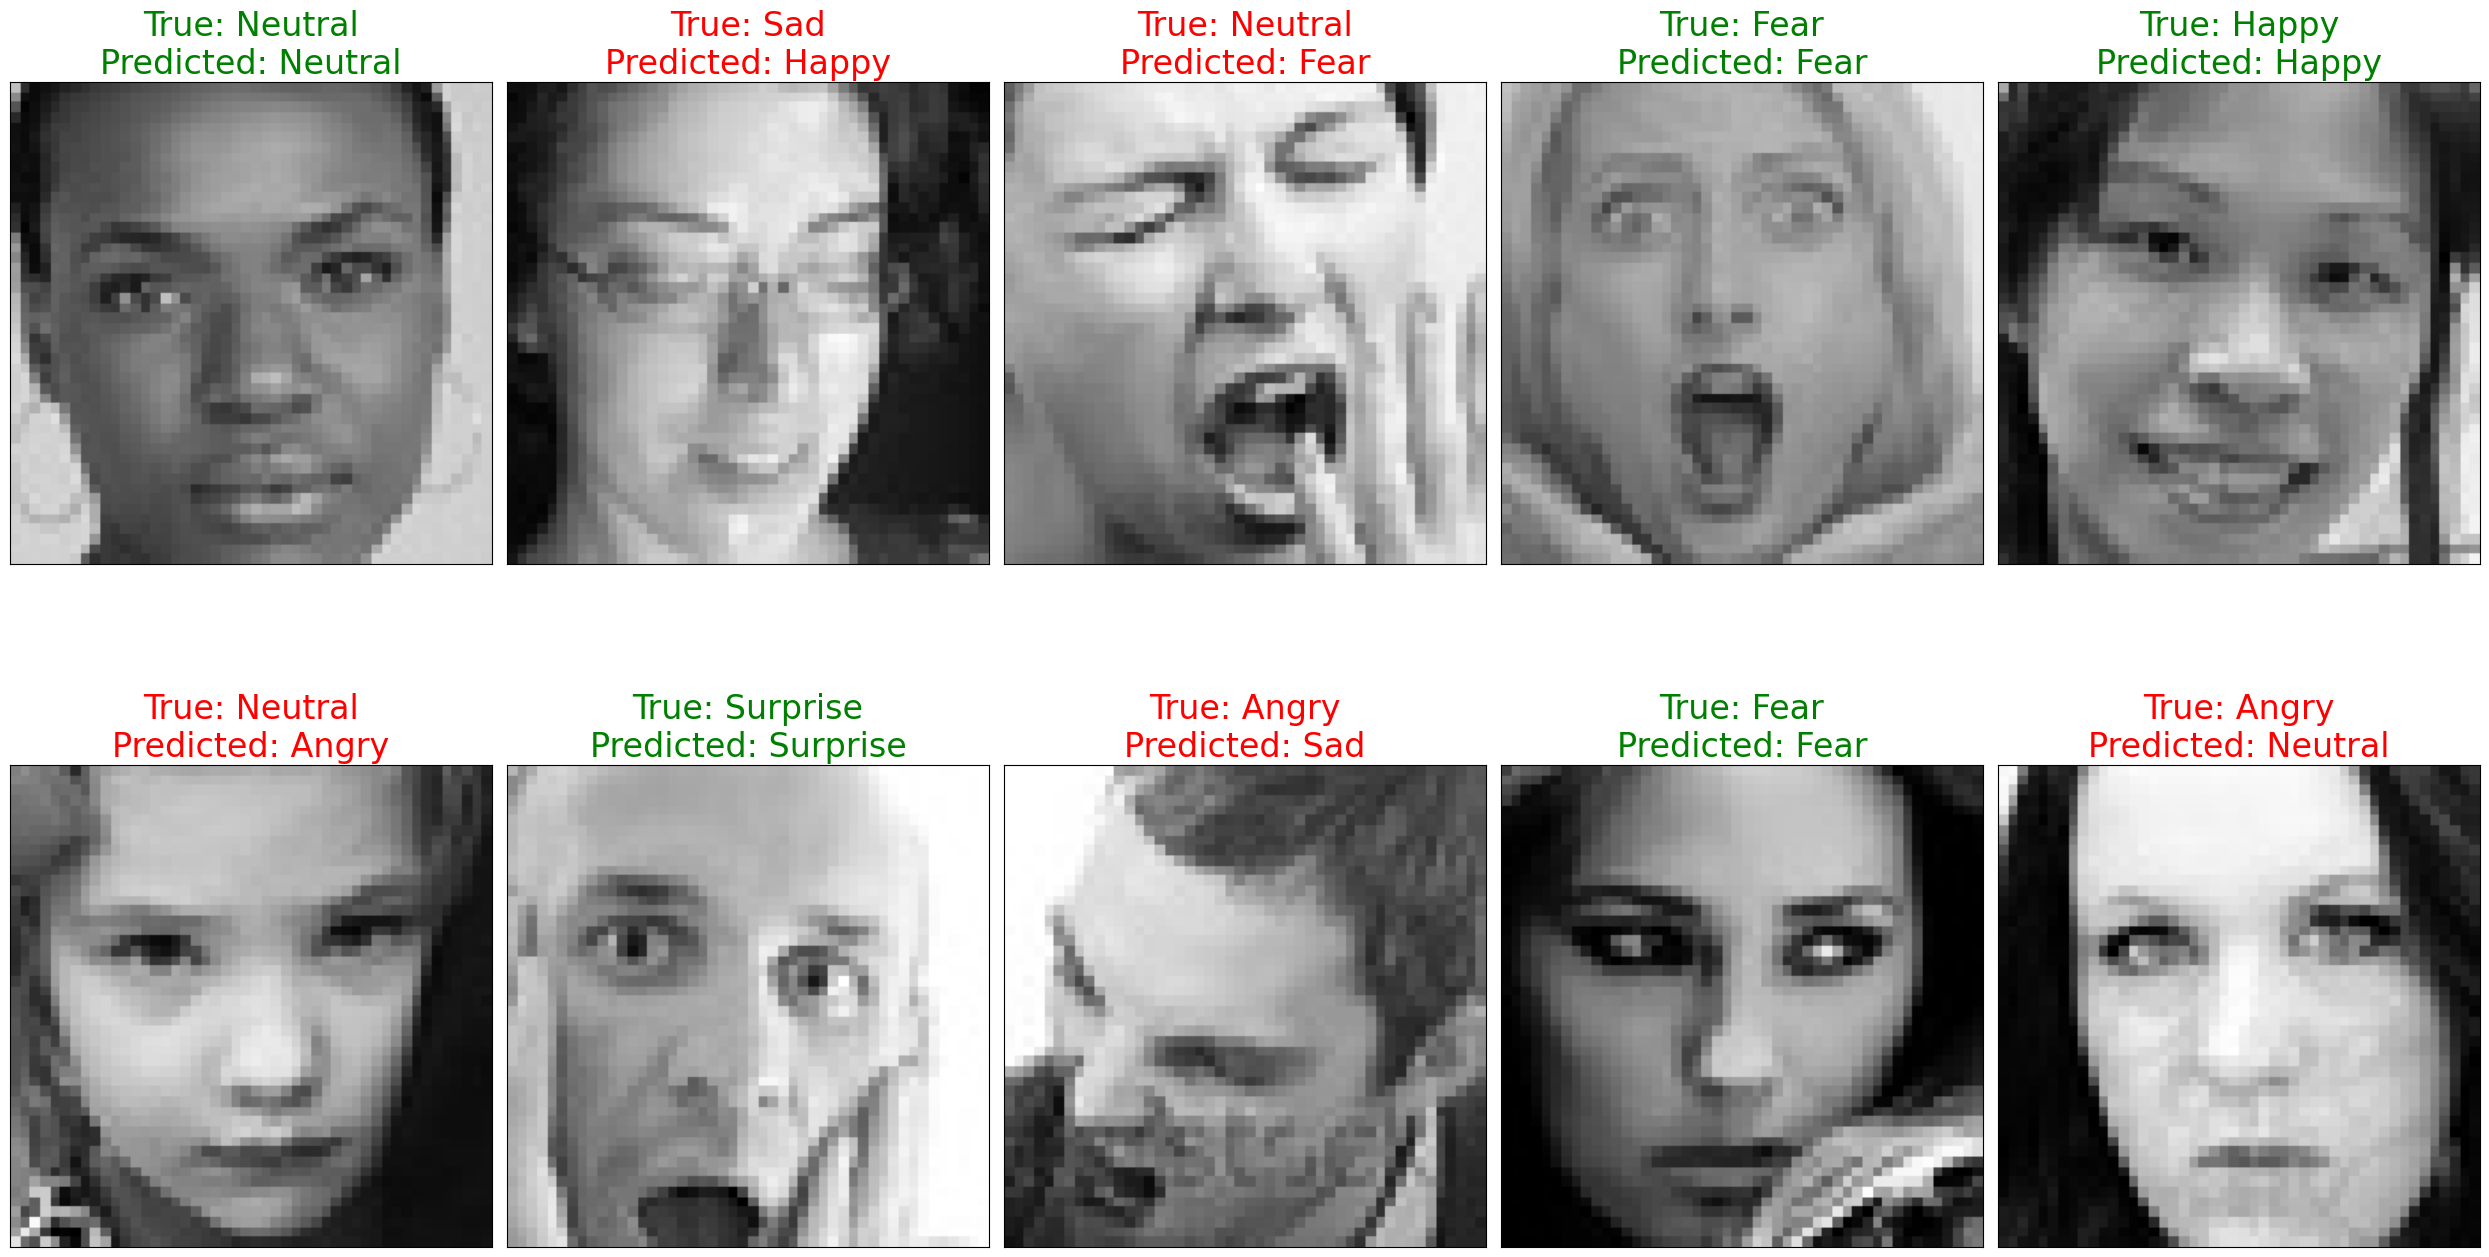

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Assuming test_generator contains your image data
# batch_size is the size of the batch
# Emotion_Classes is a list containing emotion classes

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_resized = resize(Random_Img, (224, 224), anti_aliasing=True)

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(MobileNet_Model.predict(Random_Img_resized.reshape(1, 224, 224, 3), verbose=0))

    ax.imshow(Random_Img_resized)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
#     ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color, fontsize=24)

plt.tight_layout()
plt.show()


# **Music Recommendations**

In [ ]:
# Music_Player = pd.read_csv("../input/spotify-music-data-to-identify-the-moods/data_moods.csv")
# Music_Player = Music_Player[['name','artist','mood','popularity']]
# Music_Player.head()

,name,artist,mood,popularity
0,1999,Prince,Happy,68
1,23,Blonde Redhead,Sad,43
2,9 Crimes,Damien Rice,Sad,60
3,99 Luftballons,Nena,Happy,2
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic,60


In [ ]:
# Music_Player["mood"].value_counts()

Sad          197
Calm         195
Energetic    154
Happy        140
Name: mood, dtype: int64

In [ ]:
# Music_Player["popularity"].value_counts()

0     92
51    23
52    22
50    21
55    21
      ..
80     1
2      1
14     1
15     1
88     1
Name: popularity, Length: 83, dtype: int64

In [ ]:
# Play = Music_Player[Music_Player['mood'] =='Calm' ]
# Play = Play.sort_values(by="popularity", ascending=False)
# Play = Play[:3].reset_index(drop=True)
# display(Play)

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60


In [ ]:
# Making Songs Recommendations Based on Predicted Class
# def Recommend_Songs(pred_class):
    # 
    # if( pred_class=='Disgust' ):
# 
        # Play = Music_Player[Music_Player['mood'] =='Sad' ]
        # Play = Play.sort_values(by="popularity", ascending=False)
        # Play = Play[:5].reset_index(drop=True)
        # display(Play)
# 
    # if( pred_class=='Happy' or pred_class=='Sad' ):
# 
        # Play = Music_Player[Music_Player['mood'] =='Happy' ]
        # Play = Play.sort_values(by="popularity", ascending=False)
        # Play = Play[:5].reset_index(drop=True)
        # display(Play)
# 
    # if( pred_class=='Fear' or pred_class=='Angry' ):
# 
        # Play = Music_Player[Music_Player['mood'] =='Calm' ]
        # Play = Play.sort_values(by="popularity", ascending=False)
        # Play = Play[:5].reset_index(drop=True)
        # display(Play)
# 
    # if( pred_class=='Surprise' or pred_class=='Neutral' ):
# 
        # Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        # Play = Play.sort_values(by="popularity", ascending=False)
        # Play = Play[:5].reset_index(drop=True)
        # display(Play)

In [ ]:
Example Testing
# Recommend_Songs("Fear")

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")    

zsh:1: command not found: wget


In [ ]:
import cv2
import matplotlib.pyplot as plt

def load_and_prep_image(filename, img_shape = 48):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    for x,y,w,h in faces:
        
        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        
        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]
    
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg



In [ ]:
def pred_and_plot(filename, class_names, size):

    # Import the target image and preprocess it
    Random_Img = load_and_prep_image(filename, size)

    # Make a prediction
    Model_Prediction = np.argmax(MobileNet_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))
    pred_class = class_names[Model_Prediction]
    print("Sentiment Identified as: ", pred_class)
   
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()
    print()
    # print("*" * 8, "Recommended Music", "*" * 8)
    print()
    # Recommend_Songs(pred_class)


Sentiment Identified as:  Happy


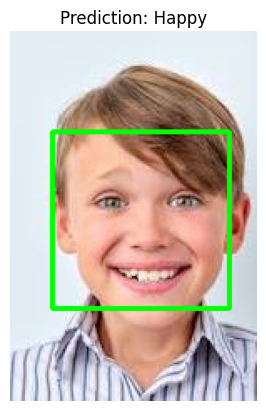

In [ ]:
pred_and_plot("/Users/tanishamaheshwari/Downloads/images.jpeg", Emotion_Classes, 224)

Sentiment Identified as:  Sad


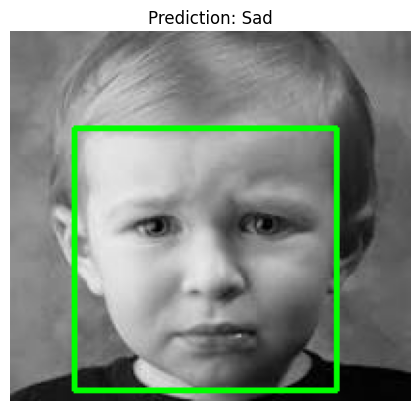

In [ ]:
pred_and_plot("/Users/tanishamaheshwari/Downloads/images-2.jpeg", Emotion_Classes, 224)

In [ ]:
MobileNet_Model.save("8thsem_project.keras")